# How to perform sentiment analisis of cryptocurrency daily reddit threads

In this tutorial our objective is to gain insights into the general mood of Reddit communities of the 3 cryptocurrencies with the highest marketcap (Bitcoin, Ethereum and Ripple). All three of these cryptocurrencies'subreddit have pinned daily discussion threads in which hundreds of people comment everyday (an example of these daily discussions for more context can be found [here](https://www.reddit.com/r/Bitcoin/comments/88996s/daily_discussion_march_30_2018/). We will be using these comments to determine a daily sentiment score for each of the 3 chosen cryptocurrencies and create a daily ranking of cryptocurrencies by sentiment and their day to day sentiment variation. We finally learn how to plot our Bitcoin Reddit daily sentiment by combining it to the chart of the Bitcoin price over the past month. 

#### 0 / Installing Libraries

#### I / Using reddit's api to find the past month's reddit daily threads' comments

#### II /  Find the sentiment of each day's daily thread

#### III / Rank the top 3 cryptocurrencies based on their sentiment

#### IV / Combine the daily price of bitcoin to its daily thread's sentiment

#### V / Conclusion

#### 0 / Installing Libraries
You will need to install the following libraries (using pip install):
    - praw: to connect to Reddit's API
    - LineCollection: to set the color of the line of a plot
    - TextBlob: we use its already trained classifier to compute the sentiment of a sentence 
    - pandas: used to group sentences by their author
    - numpy: function mean and gradient on list of floats
    - requests: to call coindesk's API for btc prices

In [1]:
from matplotlib.collections import LineCollection
import praw
from textblob import TextBlob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import math
import requests

#### I / Using reddit's api to find the past month's reddit daily threads' comments


In order to use the Reddit API, our first step here is to create a reddit account. We must then create an app at this [link](https://www.reddit.com/prefs/apps)

This app will provide credentials you will need to authentify with the API in the following code.

more information about Reddit's API called praw can be found [here](https://praw.readthedocs.io/en/latest/getting_started/quick_start.html)

In [2]:
reddit = praw.Reddit(client_id='YOUR_CLIENT_ID',
                     client_secret='YOUR_CLIENT-SECRET',
                     user_agent='sentiment analysis on crypto threads')

Version 5.3.0 of praw is outdated. Version 5.4.0 was released 2 days ago.


Now that we are connected to Reddit's API, we need to retrieve the comments of each of the past month's daily threads. We will then be able to study the comments of these threads to find the daily sentiment of a cryptocurrency. 

Luckily for us most of daily threads of the top crytocurrencies' subreddits each start all their daily threads with a common substring such as 'Daily General Discussion -' for Ethereum or 'Daily Discussion' for Bitcoin. This allows us to retrieve only the relevant daily threads and not other discussions.

To this end we will create the function "findDailyThreads". Given a subreddit's name and a search query this function will find the past month's (31 days) daily threads.

We use the subreddit.search api call which returns the newest (by date) threads containing our search query. We also pass as parameter a limit on the number results returned of 50. This limit is higher than the needed 31 daily threads. The reason for this is that we have to filter out threads which name contains the search query but does not start with it (for example: "Is there a site that still tracks days destroyed? I've asked a couple times and it gets lost in the "Daily Discussion" bullshit."). These posts are very rare and we can observe there is a very low probability that there will be more than 5-10 in a given month.


In [3]:
def findDailyThreads(SubredditName, SearchQuery):
    # fetch subreddit by giving as paramter its unique name
    subreddit = reddit.subreddit(SubredditName)
    
    # search subreddit for the 50 newest posts containing search query
    submissions = subreddit.search(SearchQuery, limit=50, sort='new')
    
    # filter out submissions which titles do not start with exactly our search query
    filteredSubmissions = [submission for submission in submissions if submission.title.startswith(SearchQuery)]

    # limit returned submissions to a month of daily threads (31 days)
    filteredSubmissions = filteredSubmissions[:31]
    
    return filteredSubmissions


ethereumDailyThreads = findDailyThreads('ethtrader', 'Daily General Discussion -')
bitcoinDailyThreads = findDailyThreads('Bitcoin', 'Daily Discussion')
rippleDailyThreads = findDailyThreads('Ripple', 'Daily Ripple/XRP Discussion Thread')

threads = {
    'bitcoin':bitcoinDailyThreads,
    'ethereum':ethereumDailyThreads,
    'ripple':rippleDailyThreads
}

#### II / Find the sentiment of each day's daily thread

The TextBlob library is useful to us as it contains already trained text classifiers. We are therefore spared the cumbersome task of deciding whether a sentence is positive or negative ourselves. 

In this second part we will compute the sentiment score of each day of the past month. To do this we will look at the comments of each daily thread. We can then split comments in sentences and group these sentences by their author (commenter). 
We then compute each author's sentiment by using the library TextBlob's property sentence.sentiment on each sentence written by the author. 
Finally, we average the sentiments of all unique authors to find the sentiment of the day.

It is important to not simply average the sentiment of all sentences on the thread. Otherwise, one person who posts a high ammount of strongly negative or positive comments could skew our daily sentiment.

In addition to the daily sentiment we also compute the total number of unique authors and the number of comments of the daily threads. This additional data is not used further in this tutorial but you may find it useful for other purposes.

In [4]:
def findSentimentOfThread(submission):
    # find all comments/replies of a thread.
    # the replace_more function fetches comments hidden by the place
    # holder "replace_more"
    submission.comments.replace_more(limit=0)
    all_comments = submission.comments.list()
    
    # total number of comments on this thread
    numberComments = len(all_comments)
    
    # for each comment, seperare comment in sentences.
    # Then create a authorname, sentence.sentiment pair
    authorSentiment = []
    for comment in all_comments:
        text = str(comment.body)
        # use the Textblob library to seperate 
        # a paragraph into sentences
        tB = TextBlob(text)
        for sentence in tB.sentences:
            if comment.author != None:
                # Textblob computes a sentiment (between -1 (neg) and 1 (pos)) using a pre-trained
                # sentiment analyzer. We use the polarity attribute of the sentiment to which indicates
                # how positive/negative the sentiment is
                authorSentiment.append((comment.author.name, sentence.sentiment.polarity))
    
    # We create a Dataframe with the above data so that we 
    # can use pandas' groupby and aggregate functions
    df = pd.DataFrame({
        'author': [sentiment[0] for sentiment in authorSentiment],
        'sentiment':[sentiment[1] for sentiment in authorSentiment]
    })

    # we filter out sentiment which are neutral as they are not relevant to us
    df = df[df['sentiment'] != 0]

    # group sentiments by common author
    groupedByAuthor = df.groupby('author')
    
    # total number of unique comment authors
    authors = len(groupedByAuthor.count())

    # compute mean of sentiments for each author.
    # This gives us the author's sentiment
    result = groupedByAuthor['sentiment'].agg([np.mean])

    # mean of all author sentiments.
    # This gives us the thread's general sentiment score
    result = np.mean(result)
    
    sentiment = result.values[0]
    
    print (submission.title + "'s sentiment is " + str(sentiment) +
           " with " + str(authors) + " commenters and " +
           str(numberComments) + " comments")
    
    return {
    'sentiment':sentiment,
    'authors':authors,
    'numberComments':numberComments
    }


In [5]:
data = {}
# compute sentiment of each daily thread for each of the three cryptocurrencies
for coinName, coinThread in threads.items():
    data[coinName] = [findSentimentOfThread(dailyThread) for dailyThread in coinThread]


Daily Discussion, March 30, 2018's sentiment is 0.11949147913120454 with 129 commenters and 478 comments
Daily Discussion, March 29, 2018's sentiment is 0.1151945273274639 with 178 commenters and 497 comments
Daily Discussion, March 28, 2018's sentiment is 0.12221018423361078 with 141 commenters and 474 comments
Daily Discussion, March 27, 2018's sentiment is 0.15981540934269564 with 153 commenters and 462 comments
Daily Discussion, March 26, 2018's sentiment is 0.11554262021903407 with 150 commenters and 455 comments
Daily Discussion, March 25, 2018's sentiment is 0.09447098059949874 with 95 commenters and 368 comments
Daily Discussion, March 24, 2018's sentiment is 0.07739837618891814 with 86 commenters and 300 comments
Daily Discussion, March 23, 2018's sentiment is 0.13238458396900615 with 103 commenters and 463 comments
Daily Discussion, March 22, 2018's sentiment is 0.11350548365016544 with 127 commenters and 466 comments
Daily Discussion, March 21, 2018's sentiment is 0.18832000

Daily Ripple/XRP Discussion Thread 03/20/18 [Questions and Price Predictions]'s sentiment is 0.08671932086825704 with 47 commenters and 113 comments
Daily Ripple/XRP Discussion Thread 03/19/18 [Questions and Price Predictions]'s sentiment is 0.2002678639947158 with 54 commenters and 129 comments
Daily Ripple/XRP Discussion Thread 03/18/18 [Questions and Price Predictions]'s sentiment is 0.07796623588014831 with 65 commenters and 165 comments
Daily Ripple/XRP Discussion Thread 03/17/18 [Questions and Price Predictions]'s sentiment is 0.08976921406463331 with 46 commenters and 106 comments
Daily Ripple/XRP Discussion Thread 03/16/18 [Questions and Price Predictions]'s sentiment is 0.21855159494339801 with 48 commenters and 118 comments
Daily Ripple/XRP Discussion Thread 03/15/18 [Questions and Price Predictions]'s sentiment is 0.22291301646794665 with 46 commenters and 117 comments
Daily Ripple/XRP Discussion Thread 03/14/18 [Questions and Price Predictions]'s sentiment is 0.131871858844

In [6]:
# only keep sentiment score, filter out the number of authors and comments
for coinName, coinThread in data.items():
    data[coinName] = [dailyThread['sentiment'] for dailyThread in coinThread]

#### III / Rank the top 3 cryptocurrencies based on their sentiment

In this third part we assign a daily rank to each of the cryptocurrencies based on their sentiment score.

We will create a ranking based on the brute sentiment value returned by the Textblob library's sentiment analysis as well as on the gradient of this vector of daily sentiment score. Indeed, as with the price, variations of sentiment might offer interesting insights about a cryptocurrency community's state of mind and thus of the cryptocurrency itself's situation.

In [7]:
# for each of the past 31 days
for i in range(0,31):
    sentimentsOfDay = []
    for coinName, coinSentiments in data.items():
        sentimentsOfDay.append(coinSentiments[i])
    
    # reverse list so that it goes from positive to negative
    sentimentsOfDay = sorted(sentimentsOfDay)[::-1]
    
    
    print('\n' + str(i + 1) + ' days ago:')
    position = 1;
    # for each cryptocurrency print position
    for sentimentOfDay in sentimentsOfDay:
        for coinName, coinThread in data.items():
            if sentimentOfDay == coinThread[i]:
                print(coinName + "'s position is " + str(position) + "  sentiment score" + str(sentimentOfDay))
        position += 1
    
    
    
    


1 days ago:
ripple's position is 1  sentiment score0.1325603300208563
ethereum's position is 2  sentiment score0.1318708249478354
bitcoin's position is 3  sentiment score0.11949147913120454

2 days ago:
bitcoin's position is 1  sentiment score0.1151945273274639
ripple's position is 2  sentiment score0.09473042559922959
ethereum's position is 3  sentiment score0.08698111632250001

3 days ago:
ripple's position is 1  sentiment score0.17916011936406676
bitcoin's position is 2  sentiment score0.12221018423361078
ethereum's position is 3  sentiment score0.09555408493985965

4 days ago:
ripple's position is 1  sentiment score0.22798940997274333
bitcoin's position is 2  sentiment score0.15981540934269564
ethereum's position is 3  sentiment score0.11299745950662748

5 days ago:
ripple's position is 1  sentiment score0.12058729798996214
bitcoin's position is 2  sentiment score0.11554262021903407
ethereum's position is 3  sentiment score0.11071968410953623

6 days ago:
ripple's position is 1  s

In [8]:
# for each of the past 31 days
for i in range(0,31):
    gradientsentimentsOfDay = []
    for coinName, coinSentiments in data.items():
        gradientsentimentsOfDay.append(np.gradient(coinSentiments)[i])
    # reverse list so that it goes from positive to negative
    gradientsentimentsOfDay = sorted(gradientsentimentsOfDay)[::-1]
    
    # for each cryptocurrency print position
    print('\n' + str(i + 1) + ' days ago:')
    position = 1;
    for gradientsentimentOfDay in gradientsentimentsOfDay:
        for coinName, coinThread in data.items():
            if gradientsentimentOfDay == np.gradient(coinThread)[i]:
                print(coinName + "'s position is " + str(position) + "  sentiment score gradient" + str(gradientsentimentOfDay))
        position += 1


1 days ago:
bitcoin's position is 1  sentiment score gradient-0.004296951803740651
ripple's position is 2  sentiment score gradient-0.0378299044216267
ethereum's position is 3  sentiment score gradient-0.04488970862533538

2 days ago:
ripple's position is 1  sentiment score gradient0.02329989467160523
bitcoin's position is 2  sentiment score gradient0.001359352551203119
ethereum's position is 3  sentiment score gradient-0.018158370003987873

3 days ago:
ripple's position is 1  sentiment score gradient0.06662949218675687
bitcoin's position is 2  sentiment score gradient0.022310441007615874
ethereum's position is 3  sentiment score gradient0.013008171592063737

4 days ago:
ethereum's position is 1  sentiment score gradient0.00758279958483829
bitcoin's position is 2  sentiment score gradient-0.003333782007288358
ripple's position is 3  sentiment score gradient-0.02928641068705231

5 days ago:
ethereum's position is 1  sentiment score gradient0.011952130526077381
bitcoin's position is 2  

#### IV / Combine the daily price of bitcoin to its daily reddit sentiment

In this last part we combine the the daily price of bitcoin to its daily reddit sentiment. 
We start by fetching the price of the bitcoin over the past month by using coindesk's REST API. The two parmeters of the api call are the start and end dates of the past month. 

In [9]:
# use the requests library to call the coindesk API
r = requests.get('https://api.coindesk.com/v1/bpi/historical/close.json?start=2018-02-28&end=2018-03-30').json()
print(r)
# select only the price from json data
prices = [price for (date, price) in r['bpi'].items()]
prices = np.array(prices)

{'bpi': {'2018-02-28': 10309.6413, '2018-03-01': 10907.59, '2018-03-02': 11019.5213, '2018-03-03': 11438.6513, '2018-03-04': 11479.7313, '2018-03-05': 11432.9825, '2018-03-06': 10709.5275, '2018-03-07': 9906.8, '2018-03-08': 9299.2838, '2018-03-09': 9237.05, '2018-03-10': 8787.1638, '2018-03-11': 9532.7413, '2018-03-12': 9118.2713, '2018-03-13': 9144.1475, '2018-03-14': 8196.8975, '2018-03-15': 8256.9938, '2018-03-16': 8269.3275, '2018-03-17': 7862.1088, '2018-03-18': 8196.0225, '2018-03-19': 8594.1913, '2018-03-20': 8915.9038, '2018-03-21': 8895.4, '2018-03-22': 8712.8913, '2018-03-23': 8918.7438, '2018-03-24': 8535.8938, '2018-03-25': 8449.835, '2018-03-26': 8138.3363, '2018-03-27': 7790.1575, '2018-03-28': 7937.205, '2018-03-29': 7086.4875, '2018-03-30': 6844.3213}, 'disclaimer': 'This data was produced from the CoinDesk Bitcoin Price Index. BPI value data returned as USD.', 'time': {'updated': 'Mar 31, 2018 00:03:00 UTC', 'updatedISO': '2018-03-31T00:03:00+00:00'}}


We then normalize and reverse the sentiments data to prepare it for being plotted.

In [10]:
def normalizeAndReverse(sentiments):
    maxS = np.max(sentiments)
    minS = np.min(sentiments)
    normalized = [(sentiment - minS) / (maxS - minS) for sentiment in sentiments]
    #inverse to plot in right order
    normalizedAndReversed = normalized[::-1]
    return np.array(normalizedAndReversed)


sentiments = normalizeAndReverse(data['bitcoin'])

Finnally we use the matplotlib library to display the price of the bitcoin in the color of its daily sentiment.

We first create segments by connecting daily price datapoints together. Then we assign a color to each segment depending on its sentiment score. More details of this process can be found in matplotlib's online documentation ([here]( https://matplotlib.org/gallery/lines_bars_and_markers/multicolored_line.html))

We can then add a colorbar as a legend to provide scale of the sentiment in function of the color.

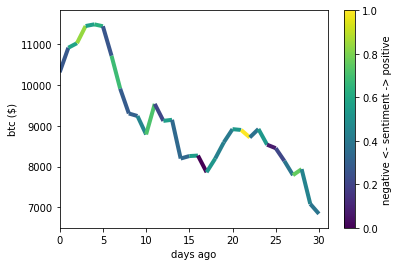

In [11]:
def draw(values, prices):
    # create a range from 0 to 30 representing the last month
    dates = [i for i in range(31)]
    
    # create segments between points of the chart of bitcoin price
    points = np.array([dates, prices]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    fig, axs = plt.subplots()
    # Create a continuous norm to map from data points to colors
    norm = plt.Normalize(values.min(), values.max())
    
    lc = LineCollection(segments, norm=norm)
    # Set the values used for colormapping
    lc.set_array(values)
    lc.set_linewidth(4)
    
    # add colored line to plot
    line = axs.add_collection(lc)
    
    # add color bar as legend for sentiment from negative to positive
    fig.colorbar(line, ax=axs, label='negative <- sentiment -> positive')
    
    # add a distance of 5% of the max price vertical buffer for a better view of the graph
    axs.set_ylim(prices.min() - prices.min() * 0.05, prices.max() + prices.min() * 0.05)
    axs.set_xlim(0, 31)
    
    # add labels
    axs.set(xlabel='days ago', ylabel='btc ($)')
    
    plt.show()

draw(sentiments, prices)

In this plot we can see that the daily price of the bitcoin is not directly correlated to the sentiment of its reddit daily threads. Indeed a high price does not seem to mean that the sentiment of the day is high. It seems that there is a small correlation however with the variation of the price however. Indeed, we see darker shades for the sentiment as the price decreases strongly compared to when it rises or is very high.

#### V / Conclusion

We now know how to:
    - use the Reddit API to search threads with a specific search query
    - use the Reddit API to find all comments of a reddit thread
    - use the Textblob library to compute the sentiment of a sentence
    - group comments by author and compute author's mean sentiment
    - Fetch bitcoin prices for a specific date range
    - graphically overlap the daily sentiment to the bitcoin price plot
    - rank the top cryptocurrencies based on their sentiment and sentiment day to day variation
    
The results gathered in this tutorial may still be further improved. A great improvement would be to switch from the pretrained general sentiment tool from the Textblob library to one trained specifically on the cryptocurrency lexical scope. The following [blog post](https://medium.com/@cryptopredicted/sentiment-analysis-for-predicting-cryptocurrency-prices-66282b0ac9a6) is an example of a more precise sentiment analisis on crytpocurrencies.